In [45]:
#Importing relevant libraries
from keras.applications import InceptionV3
import keras_metrics as km

In [46]:
#Defining the directories for the training, validation and test data

base_dir = 'D:/Education/Makerere/Research/Implementation/final_images'

train_dir = base_dir+'/training'
validation_dir = base_dir+'/validation'
test_dir = base_dir+'/test'

In [47]:
conv_base = InceptionV3(weights='imagenet',
                  include_top=False, #not using the pre-trained classifier 
                  input_shape=(400, 400, 3)
                 )
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 199, 199, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 199, 199, 32) 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 199, 199, 32) 0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_190

In [48]:
import os
import numpy as np

In [49]:
from keras.preprocessing.image import ImageDataGenerator

In [50]:
datagen = ImageDataGenerator(rescale = 1./255)

In [51]:
batch_size = 5

In [52]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 11, 11, 2048))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(400, 400),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [53]:
train_features, train_labels = extract_features(train_dir, 88)

validation_features, validation_labels = extract_features(validation_dir, 30)

test_features, test_labels = extract_features(test_dir, 30)

Found 88 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [54]:
train_features = np.reshape(train_features, (88, 11 * 11 * 2048))
validation_features = np.reshape(validation_features, (30, 11 * 11 * 2048))
test_features = np.reshape(test_features, (30, 11 * 11 * 2048))

In [55]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=11 * 11 * 2048))
model.add(layers.Dropout(0.001))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc', km.binary_precision(), km.binary_recall()])

history = model.fit(train_features, train_labels,
                    epochs=4,
                    batch_size=5,
                    validation_data=(validation_features, validation_labels))

Train on 88 samples, validate on 30 samples
Epoch 1/4
88/88 [==============================] - 12s 132ms/step - loss: 1.1453 - acc: 0.7614 - precision: 0.7805 - recall: 0.7273 - val_loss: 0.8021 - val_acc: 0.8000 - val_precision: 0.7143 - val_recall: 1.0000
Epoch 2/4
88/88 [==============================] - 10s 118ms/step - loss: 0.1828 - acc: 0.9091 - precision: 0.9091 - recall: 0.9091 - val_loss: 0.5444 - val_acc: 0.8667 - val_precision: 1.0000 - val_recall: 0.7333
Epoch 3/4
88/88 [==============================] - 10s 117ms/step - loss: 0.0117 - acc: 0.9886 - precision: 1.0000 - recall: 0.9773 - val_loss: 0.2093 - val_acc: 0.9000 - val_precision: 0.9286 - val_recall: 0.8667
Epoch 4/4
88/88 [==============================] - 10s 117ms/step - loss: 5.2913e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2119 - val_acc: 0.9333 - val_precision: 1.0000 - val_recall: 0.8667


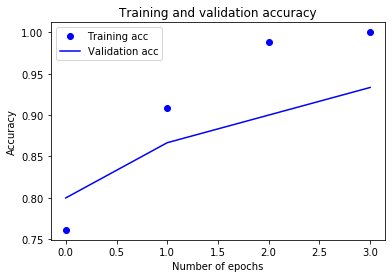

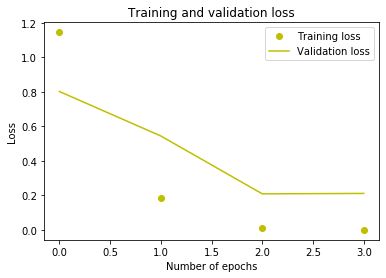

<Figure size 432x288 with 0 Axes>

In [56]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'yo', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.show()

In [57]:
test_loss, test_acc, test_precision, test_recall  = model.evaluate(test_features, test_labels)
print('test accuracy is:', test_acc)
print('test precision is:', test_precision)
print('test recall is:', test_recall)

30/30 [==============================] - 0s 3ms/step
test accuracy is: 0.8333333134651184
test precision is: 0.7777777734567901
test recall is: 0.9333333271111112


## Using data augmentation

In [58]:
from keras import models
from keras import layers

#adding a densely connected classifier on top of the convolutional base
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 11, 11, 2048)      21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 247808)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               63439104  
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 85,242,145
Trainable params: 85,207,713
Non-trainable params: 34,432
_________________________________________________________________


In [59]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 192
This is the number of trainable weights after freezing the conv base: 4


In [60]:
#Training the model end to end with a frozen convolutional base

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import keras_metrics as km

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(400, 400),
                                                    batch_size=5,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(400, 400),
                                                        batch_size=5,
                                                        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc', km.binary_precision(), km.binary_recall()])

history = model.fit_generator(train_generator,
                              steps_per_epoch=30,
                              epochs=3,
                              validation_data=validation_generator,
                              validation_steps=50)

Found 88 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Epoch 1/3
30/30 [==============================] - 144s 5s/step - loss: 4.4466 - acc: 0.5222 - precision: 0.5050 - recall: 0.7083 - val_loss: 0.8232 - val_acc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/3
30/30 [==============================] - 144s 5s/step - loss: 0.6799 - acc: 0.6601 - precision: 0.6753 - recall: 0.6842 - val_loss: 0.6625 - val_acc: 0.6400 - val_precision: 0.8302 - val_recall: 0.3520
Epoch 3/3
30/30 [==============================] - 145s 5s/step - loss: 0.5601 - acc: 0.7378 - precision: 0.7500 - recall: 0.7083 - val_loss: 0.7252 - val_acc: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000


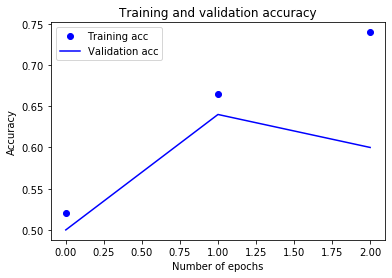

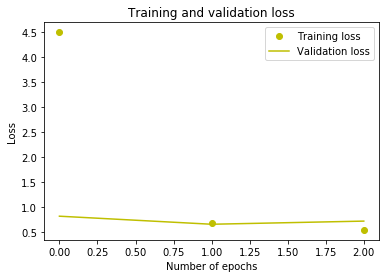

<Figure size 432x288 with 0 Axes>

In [61]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'yo', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.show()

In [62]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(400, 400),
                                                  batch_size=5,
                                                  class_mode='binary')

#test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
#print('test acc:', test_acc)

test_loss, test_acc, test_precision, test_recall  = model.evaluate_generator(test_generator, steps=50)
print('test accuracy is:', test_acc)
print('test precision is:', test_precision)
print('test recall is:', test_recall)

Found 30 images belonging to 2 classes.
test accuracy is: 0.5000000122189522
test precision is: 0.49999999980000004
test recall is: 0.9999999992


## Finetuning

In [63]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 199, 199, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 199, 199, 32) 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 199, 199, 32) 0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_190

In [64]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'activation_86':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [65]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import keras_metrics as km

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(400, 400),
                                                    batch_size=5,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(400, 400),
                                                        batch_size=5,
                                                        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-10),
              metrics=['acc', km.binary_precision(), km.binary_recall()])

Found 88 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [66]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=20,
                              epochs=3,
                              validation_data=validation_generator,
                              validation_steps=50)

Epoch 1/3
20/20 [==============================] - 128s 6s/step - loss: 0.8497 - acc: 0.6733 - precision: 0.6000 - recall: 1.0000 - val_loss: 0.4654 - val_acc: 0.7680 - val_precision: 0.6848 - val_recall: 1.0000
Epoch 2/3
20/20 [==============================] - 118s 6s/step - loss: 0.8592 - acc: 0.6733 - precision: 0.6145 - recall: 1.0000 - val_loss: 0.4752 - val_acc: 0.7600 - val_precision: 0.6721 - val_recall: 1.0000
Epoch 3/3
20/20 [==============================] - 117s 6s/step - loss: 0.9002 - acc: 0.6497 - precision: 0.5977 - recall: 1.0000 - val_loss: 0.5140 - val_acc: 0.7360 - val_precision: 0.6562 - val_recall: 1.0000


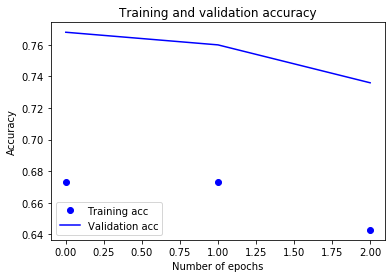

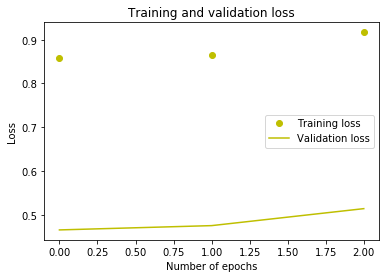

<Figure size 432x288 with 0 Axes>

In [67]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'yo', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.show()

In [68]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(400, 400),
                                                  batch_size=5,
                                                  class_mode='binary')

#test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
#print('test acc:', test_acc)

test_loss, test_acc, test_precision, test_recall  = model.evaluate_generator(test_generator, steps=50)
print('test accuracy is:', test_acc)
print('test precision is:', test_precision)
print('test recall is:', test_recall)

Found 30 images belonging to 2 classes.
test accuracy is: 0.5280000123381615
test precision is: 0.5123966940031419
test recall is: 0.9999999991935484
